## Prepare

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler 
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(dtype)

<class 'torch.cuda.FloatTensor'>


60000
10000
tensor([6, 0, 7, 3, 8, 4, 2, 6, 7, 2, 3, 1, 9, 4, 4, 9, 8, 5, 8, 6, 9, 9, 6, 8,
        8, 3, 3, 7, 6, 1, 1, 3, 2, 1, 8, 1, 5, 7, 1, 0, 3, 1, 5, 0, 7, 3, 7, 4,
        1, 8, 1, 3, 5, 2, 7, 3, 3, 1, 4, 3, 3, 2, 8, 6, 3, 2, 6, 6, 5, 7, 8, 9,
        1, 3, 6, 1, 1, 7, 1, 2, 9, 8, 3, 8, 5, 8, 3, 6, 3, 7, 0, 2, 6, 2, 0, 3,
        2, 5, 6, 5, 0, 3, 4, 8, 7, 2, 6, 3, 1, 4, 0, 9, 1, 8, 1, 0, 8, 8, 3, 9,
        0, 8, 6, 2, 0, 0, 0, 4])


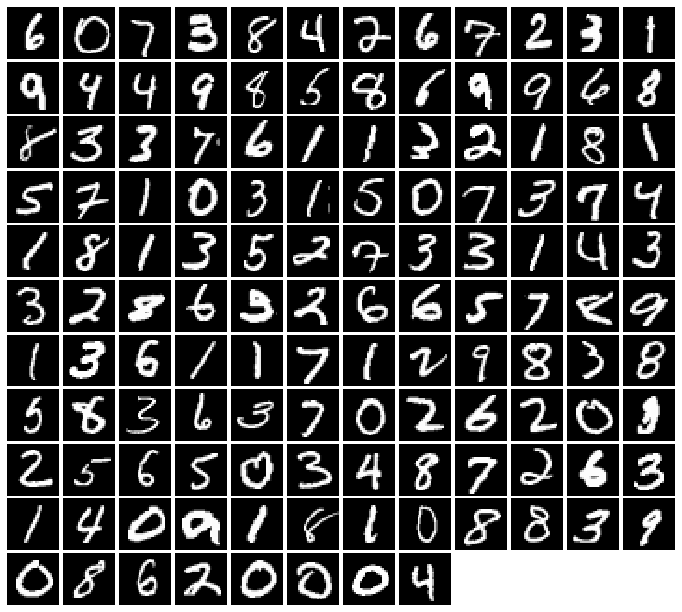

In [2]:
NUM_TRAIN = 50000
NUM_VAL = 10000
NUM_TEST = 10000
batch_size = 128
test_batch_size = 20

mnist_train = dset.MNIST('./datasets/MNIST_data', train=True, download=True, 
                        transform=T.ToTensor())
print(len(mnist_train))

loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = dset.MNIST('./datasets/MNIST_data', train=False, download=True, 
                        transform=T.ToTensor())
print(len(mnist_test))
loader_test = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=True)

img_label = loader_train.__iter__().next()
imgs = img_label[0].view(batch_size, 784).numpy().squeeze()
labels = img_label[1].squeeze()
print(labels)
show_images(imgs)

using formula to vectorize the implementation
$$out_{ij} = \sum_{k=0}^{s-1}{(te_{ik} - tr_{kj})}^2 = \sum_{k=0}^{s-1}{te_{ik}^2 + tr_{kj}^2 - 2 te_{ik} tr_{kj}}$$

In [3]:
def compute_distance(x_train, x_test):
    x_train = x_train.reshape(x_train.shape[0],-1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    dist = np.sum(x_test * x_test, axis = 1).reshape(-1,1) - 2 * x_test.dot(x_train.T) + np.sum(x_train * x_train, axis = 1)
    return dist

In [4]:
x, y = next(DataLoader(mnist_train, batch_size=NUM_TRAIN+NUM_VAL, shuffle=True).__iter__())
x_train, y_train = x[0:NUM_TRAIN].numpy().squeeze(), y[0:NUM_TRAIN]
x_val, y_val = x[NUM_TRAIN:NUM_TRAIN+NUM_VAL].numpy().squeeze(), y[NUM_TRAIN:NUM_TRAIN+NUM_VAL]

dist = compute_distance(x_train, x_val)
print(dist.shape)

k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 30, 40, 50, 60, 70,100, 150, 200, 250, 300, 350] # must increase

k_to_accuracies = {}
dist = np.argsort(dist, axis = 1)
y_pred = np.zeros(NUM_VAL)
bestk = 0
bestacc = 0
for k in k_choices:
    for i in range(NUM_VAL):
        knnidx = y_train[dist[i,:k]]
        y_pred[i] = np.argmax(np.bincount(knnidx))
    k_to_accuracies[k] = np.sum(y_pred == y_val.numpy()) / NUM_VAL
    print('k = ', k, '\taccuracy = ', k_to_accuracies[k])
    if(k_to_accuracies[k] > bestacc):
        bestk = k
        bestacc = k_to_accuracies[k]
k_meas = [j for i,j in k_to_accuracies.items()]
print('bestk = ', bestk)

(10000, 50000)
k =  1 	accuracy =  0.9711
k =  3 	accuracy =  0.9711
k =  5 	accuracy =  0.9707
k =  8 	accuracy =  0.9696
k =  10 	accuracy =  0.9679
k =  12 	accuracy =  0.9665
k =  15 	accuracy =  0.9653
k =  20 	accuracy =  0.9636
k =  30 	accuracy =  0.958
k =  40 	accuracy =  0.9545
k =  50 	accuracy =  0.949
k =  60 	accuracy =  0.9473
k =  70 	accuracy =  0.9442
k =  100 	accuracy =  0.9387
k =  150 	accuracy =  0.9307
k =  200 	accuracy =  0.9232
k =  250 	accuracy =  0.9164
k =  300 	accuracy =  0.9109
k =  350 	accuracy =  0.9061
bestk =  1


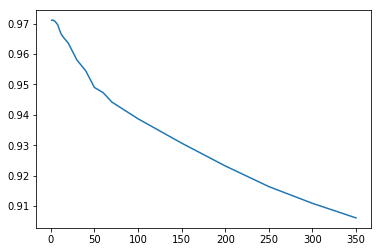

In [5]:
plt.plot(k_choices, k_meas)
plt.show()

In [6]:
x_test, y_test = next(DataLoader(mnist_train, batch_size=NUM_TEST, shuffle=True).__iter__())
dist_test = compute_distance(x_train, x_test.numpy().squeeze())   
dist_test = np.argsort(dist_test, axis = 1)
y_pred = np.zeros(NUM_TEST)
for i in range(NUM_TEST):
    knnidx = y_train[dist_test[i,:bestk]]
    y_pred[i] = np.argmax(np.bincount(knnidx))
accuracy = np.sum(y_pred == y_test.numpy()) / NUM_TEST
print('k = ', bestk, '\taccuracy = ', accuracy)

k =  1 	accuracy =  0.9944


show an example of the least 5 neighbors

1


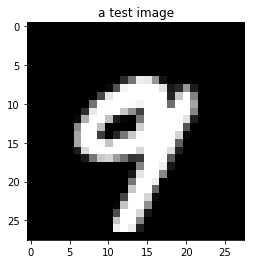

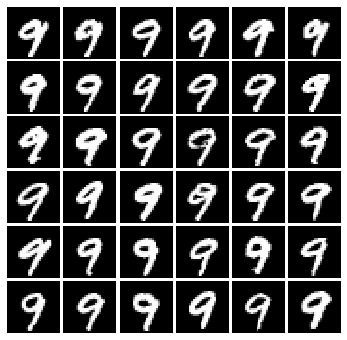

In [7]:
print(bestk)

example = x_train[dist_test[0, :36]]
plt.imshow(x_test[0].squeeze())
plt.title("a test image")
show_images(example)

using pytorch on **gpu** to accelerate the implementation

In [11]:
def compute_dist_torch(x_train, x_test):
    x_train = x_train.view(x_train.shape[0],-1)
    print(x_train.shape)
    x_test = x_test.view(x_test.shape[0], -1)
    dist = torch.sum(x_test * x_test, dim = 1).view(-1,1) - 2 * x_test.mm(x_train.t()) + torch.sum(x_train * x_train, dim = 1)
    return dist

x, y = next(DataLoader(mnist_train, batch_size=NUM_TRAIN+NUM_VAL, shuffle=True, num_workers = 4).__iter__())
x = torch.squeeze(x).type(dtype)
y = y.type(dtype).long()
x_train, y_train = x[0:NUM_TRAIN], y[0:NUM_TRAIN]
x_val, y_val = x[NUM_TRAIN:NUM_TRAIN+NUM_VAL], y[NUM_TRAIN:NUM_TRAIN+NUM_VAL]

dist = compute_dist_torch(x_train, x_val)
print(dist.shape)

k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 30, 40, 50, 60, 70,100, 150, 200, 250, 300, 350] # must increase

k_to_accuracies = {}
y_pred = torch.zeros(NUM_VAL).type(dtype).long()
bestk = 0
bestacc = 0
for i in range(NUM_VAL):
    dist[i] = torch.argsort(dist[i])
dist = dist.long()
for k in k_choices:
    for i in range(NUM_VAL):
        knnidx = y_train[dist[i,:k]]
        y_pred[i] = torch.argmax(torch.bincount(knnidx))
    del knnidx
    k_to_accuracies[k] = torch.sum(y_pred == y_val).cpu().numpy() / NUM_VAL
    print('k = ', k, '\taccuracy = ', k_to_accuracies[k])
    if(k_to_accuracies[k] > bestacc):
        bestk = k
        bestacc = k_to_accuracies[k]
k_meas = [j for i,j in k_to_accuracies.items()]
print('bestk = ', bestk)

torch.Size([50000, 784])
torch.Size([10000, 50000])
k =  1 	accuracy =  0.9717
k =  3 	accuracy =  0.9704
k =  5 	accuracy =  0.9708
k =  8 	accuracy =  0.9673
k =  10 	accuracy =  0.9666
k =  12 	accuracy =  0.9659
k =  15 	accuracy =  0.964
k =  20 	accuracy =  0.9601
k =  30 	accuracy =  0.957
k =  40 	accuracy =  0.953
k =  50 	accuracy =  0.9505
k =  60 	accuracy =  0.9469
k =  70 	accuracy =  0.9439
k =  100 	accuracy =  0.937
k =  150 	accuracy =  0.929
k =  200 	accuracy =  0.9218
k =  250 	accuracy =  0.9137
k =  300 	accuracy =  0.9087
k =  350 	accuracy =  0.9027
bestk =  1


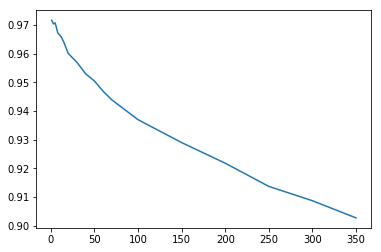

In [12]:
plt.plot(k_choices, k_meas)
plt.show()

In [16]:
x_test, y_test = next(DataLoader(mnist_train, batch_size=NUM_TEST, shuffle=True, num_workers = 4).__iter__())
x_test, y_test = torch.squeeze(x_test).type(dtype), y_test.type(dtype).long()
x_train, y_train = x_train.type(dtype), y_train.type(dtype).long()
dist = compute_dist_torch(x_train, x_test)   
for i in range(NUM_TEST):
    dist[i] = torch.argsort(dist[i])
print(dist.shape)
dist = dist.long()
y_pred = torch.zeros(NUM_TEST).type(dtype).long()
for i in range(NUM_TEST):
    knnidx = y_train[dist[i,:bestk]].long()
    y_pred[i] = torch.argmax(torch.bincount(knnidx))
accuracy = torch.sum(y_pred == y_test).cpu().numpy() / NUM_TEST
print('k = ', bestk, '\taccuracy = ', accuracy)

torch.Size([50000, 784])
torch.Size([10000, 50000])
k =  1 	accuracy =  0.9942


1


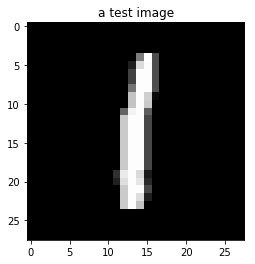

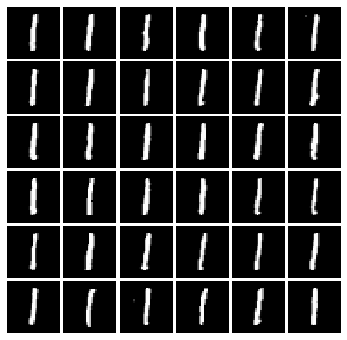

In [22]:
print(bestk)

example = x_train[dist[0, :36]].cpu().numpy()
plt.imshow(x_test[0].squeeze().cpu().numpy())
plt.title("a test image")
show_images(example)

用numpy算过一遍，还行。<br/>
接着用pytorch移植到gpu上算过一遍，效率高了些，但是由于显存有限以及bincount都没有维度接口，只有循环实现，并行不够。<br/>
还可以改进的地方——这里将dataset中训练集分成了训练集和验证集，但是这将训练集缩小了5/6。<br/>
为了训练集大小，更有可能提高精度，可以采用交叉折叠验证来选取k值，这样所有的训练集便得到了保留。